# Laplacian Associative Memory (LAM)

[Multiscale representations of community structures in attractor neural networks](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8412329/pdf/pcbi.1009296.pdf) (2021)


In [1270]:
import numpy as np
import matplotlib.pyplot as plt

In [1271]:
# np.random.seed(123)

In [1272]:
class LAM():
    def __init__(self, ndim):
        self.ndim = ndim
        self.weights = np.zeros((self.ndim, self.ndim))

    def train(self, data, threshold=0.1):
        for sample in data:
            memory = np.array([np.where(sample > threshold, 1, -1)]) # Binary dipole (+/-)
            delta_weights = memory.T * memory
            self.weights += delta_weights
            self.weights = (self.weights + self.weights.T) / 2 # Enforce symmetrical weights
        self.weights /= data.shape[0] # Normalise against dataset
        np.fill_diagonal(self.weights, 0) # Set the diagonal to zero - ensure nodes to influence themselves

    def infer(self, state, units, T):
        for _ in range(units):
            rand_idx = np.random.randint(1, self.ndim)
            spin = np.dot(self.weights[rand_idx,:], state) # Activation function
            state[rand_idx] = self.step(spin)
        return state

    def step(self, y): # Step / Threshold activation function
        return 1 if y > 0 else -1

    def sigmoid(self, x): # Continuous activation function
        return 1.0 / (1.0 + np.exp(-x))
    
    def kronecker_delta(i, j):
        return 1 if i==j else 0 

    def compute_energy(self, state): # As per original paper
        return -0.5 * np.dot(np.dot(self.weights, state), state.T)

In [1273]:
# Hyperparameters
ndim = 64
memory = 8
p = 0.1
alpha = 0.1

In [1274]:
data = np.array([1 if x > 0.5 else 0 for x in np.random.rand(ndim * memory)], dtype=np.int8)
data = data.reshape(memory, ndim)

print(data[0])
print(data.shape)

[0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0 1 1 1 0
 0 1 0 1 1 0 0 1 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 1 1 1 0]
(8, 64)


In [1275]:
# Build model
model = LAM(ndim)

In [1276]:
# Summary
w = int((ndim * (ndim - 1)) / 2)

print(ndim, "neurons")
print(w, "weighted connections")
print(f"{ndim * 0.138:.2f} point attactors")
print(f"{0.24 * w:.2f} bit capacity")

64 neurons
2016 weighted connections
8.83 point attactors
483.84 bit capacity


In [1277]:
# Train (Encoding)
model.train(data)

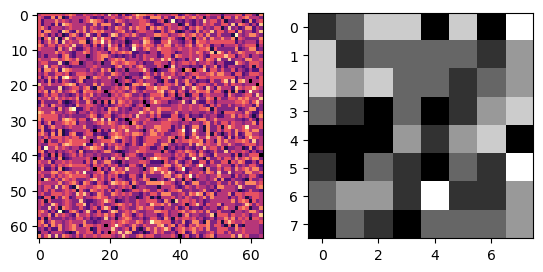

In [1278]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(model.weights, cmap='magma')

plt.subplot(1,2,2)
plt.imshow(model.weights[1].reshape(int(ndim**0.5),int(ndim**0.5)), cmap='binary')

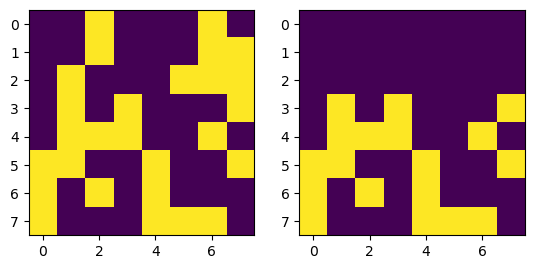

In [1279]:
# state = np.random.randint(-1,2,(model.ndim)) # Noise

plt.subplot(1,2,1)
state = data[0]
plt.imshow(state.reshape(int(ndim**0.5),int(ndim**0.5)))

plt.subplot(1,2,2)
state[:24] = 0
plt.imshow(state.reshape(int(ndim**0.5),int(ndim**0.5)))

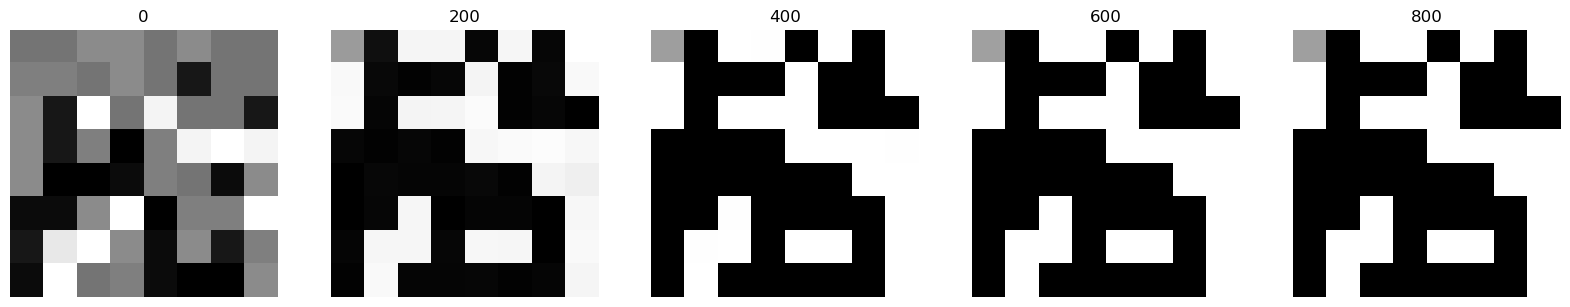

In [1280]:
# Infer (Retrieval)
steps = 1000
n_update = 16
energy = []
T = 1.0

plt.figure(figsize=(20,200))
for i in range(steps):
    state = model.infer(state, n_update, T).astype(float)
    E = model.compute_energy(state)
    energy.append(E)

    noise = np.random.randint(-1,2, state.shape) * T * 0.1 # Add disturbance
    state += noise

    T = max(T * 0.99, 0.001) # Simulated annealing

    stamp = steps / 5
    if i%stamp == 0:
        m = int((i/stamp)+1)
        plt.subplot(1, int(steps/stamp), m)
        plt.imshow(state.reshape(int(ndim**0.5),int(ndim**0.5)), cmap='binary')
        plt.title(i)
        plt.axis('off')

(Text(0.5, 0, 'Time'), Text(0, 0.5, 'Energy'))

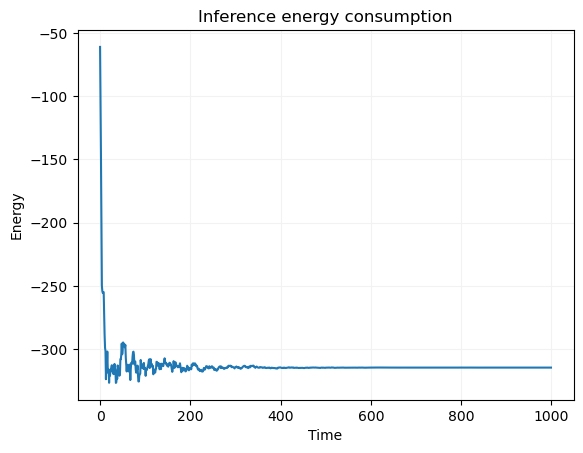

In [1281]:
x = np.arange(len(energy))
y = np.array(energy).squeeze()

plt.figure()
plt.plot(x, y)
plt.grid(axis='both', color='0.95')
plt.title('Inference energy consumption')
plt.xlabel('Time'), plt.ylabel('Energy')